# Приоритизация гипотез, запуск A/B-теста и анализ результатов. 

# Описание проекта

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты. 


**Описание данных**

Датасет `hypothesis`:
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Датасет `orders`:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Датасет `visitors`:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста


**Инструменты и навыки:**
- python
- pandas
- matplotlib
- spicy
- A/B тестирование
- проверка статистических гипотез

## Загрузка данных и подготовка их к анализу

### Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
import seaborn as sb
import numpy as np
import datetime as dt
from scipy import stats as st
from datetime import date
%config InlineBackend.figure_format = 'retina'

In [2]:
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv', sep=',') 
except:
    hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv', sep=',') 
try:
    orders = pd.read_csv('/datasets/orders.csv', sep=',') 
except:
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv', sep=',') 
    
try:
    visitors = pd.read_csv('/datasets/visitors.csv', sep=',') 
except:
    visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv', sep=',') 
  

### Предобработка и изучение датасета orders.

In [3]:
orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [4]:
orders.info() # Выведем общую информацию о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [5]:
orders.rename(columns = {'transactionId':'transaction_id', 'visitorId':'visitor_id'}, inplace = True )

In [6]:
orders.isna().sum() # Пропусков в датасете нет

transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64

In [7]:
orders.duplicated().sum() # Дубликатов тоже нет

0

In [8]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [9]:
orders.info() # Поменяем тип данных даты

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


### Предобработка и изучение датасета visitors.

In [10]:
visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [11]:
visitors.info() # Выведем общую информацию о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [12]:
visitors.isna().sum() # Пропусков в датасете нет

date        0
group       0
visitors    0
dtype: int64

In [13]:
visitors.duplicated().sum() # Дубликатов тоже нет

0

In [14]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [15]:
visitors.info() # Поменяем тип данных даты

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


### Предобработка и изучение датасета hypothesis.

In [16]:
hypothesis.head(5)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


In [17]:
hypothesis.columns = [x.lower() for x in hypothesis.columns] # Приведем названия столбцов к нижнему регистру

In [18]:
hypothesis.info() # Выведем общую информацию о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [19]:
hypothesis.isna().sum() # Пропусков в датасете нет

hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64

In [20]:
hypothesis.duplicated().sum() # Дубликатов тоже нет

0

**Вывод:**
- Загрузили данные датасетов `orders`,`visitors`,`hypothesis`
- Привели к нужным типам данные дат
- Привели к нужнему регистру и изменили названия столбцов


## Приоритизация гипотез.

### Фреймворк ICE 

Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [21]:
pd.set_option('max_colwidth', 100)
pd.set_option('display.width', 300)
hypothesis['ICE']=round((hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts'],2)
hypothesis[['hypothesis','ICE']].sort_values(by='ICE',ascending=False)


,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


По данным анализа наиболее перспективными являются гипотезы:
- 8 (Запустить акцию, дающую скидку на товар в день рождения)
- 0 (Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей)
- 7 (Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок)

### Фреймворк RICE 

Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [22]:
hypothesis['RICE']=(hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
hypothesis[['hypothesis','RICE']].sort_values(by='RICE',ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Теперь же наиболее перспективными являются гипотезы:
- 7 (Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок)
- 2 (Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа)
- 0 (Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей)
- 6 (Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию)

### Различия после применения RICE вместо ICE.

Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

In [23]:
hypothesis

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3,7.00,56.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3,8.00,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2


- Reach — охват пользователей по 10-балльной шкале
- Impact — влияние на пользователей по 10-балльной шкале
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

После применения RICE вместо ICE на первое место вышла гипотеза под номером 7, т.к у нее максимальная оценка охвата пользователей (Reach=10),
На втором месте появилась новая гипотеза под номером 2, у которой reach =8, но impact= 3, зато confidence=7.

Сохранилась гипотеза под номером 0, у нее reach=3, но impact =10.

Также появилась гипотеза 6, у нее reach=5.

### Вывод:

1. По результатам применения фреймоворка ICE наиболее наиболее перспективными являются гипотезы под номерами 8,0 и 7.
2. После применения фреймворка RICE помимо гипотез 7 и 0, появились новые гипотезы 2 и 6.
3. Основными различиями при приоритезации гипотез между фрейморками ICE и RICE является наличие параметра Reach, который показывает охват пользователей по 10-балльной шкале. Поэтому, после применения фреймоворка RICE. наиболее перспективными гипотезами стали гипотезы под номерами 7,2,0 и 6.

##  Анализ A/B-теста

Посмотрим подробнее на результаты A/B тестирования.

In [24]:
orders['group'].unique()

array(['B', 'A'], dtype=object)

In [25]:
orders.groupby('visitor_id').agg({'group':'nunique'}).value_counts()

group
1        973
2         58
dtype: int64

Всего в тестировании участвуют 2 группы (A и B).  

В обе группы попадают 58 человек, что составляет 4,8%. Доля маленькая, можем оставить эти данные, но иметь их в виду.

In [26]:
orders['date'].min()

Timestamp('2019-08-01 00:00:00')

In [27]:
orders['date'].max()

Timestamp('2019-08-31 00:00:00')

Всего тест проводился 30 дней.

### График кумулятивной выручки по группам.

Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

In [28]:
#Создадим датафрейм datesGroups с уникальными парами значений 'date' и 'group'

datesGroups=orders[['date','group']].drop_duplicates() 

In [29]:
#Объявим переменную ordersAggregated
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [30]:
#Объявим переменную visitorsAggregated

visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [31]:
#Определим переменную cumulativeData
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [32]:
# Объявим переменнцю cumulativeRevenue с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

In [33]:
# Объявим переменнцю cumulativeRevenueB с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

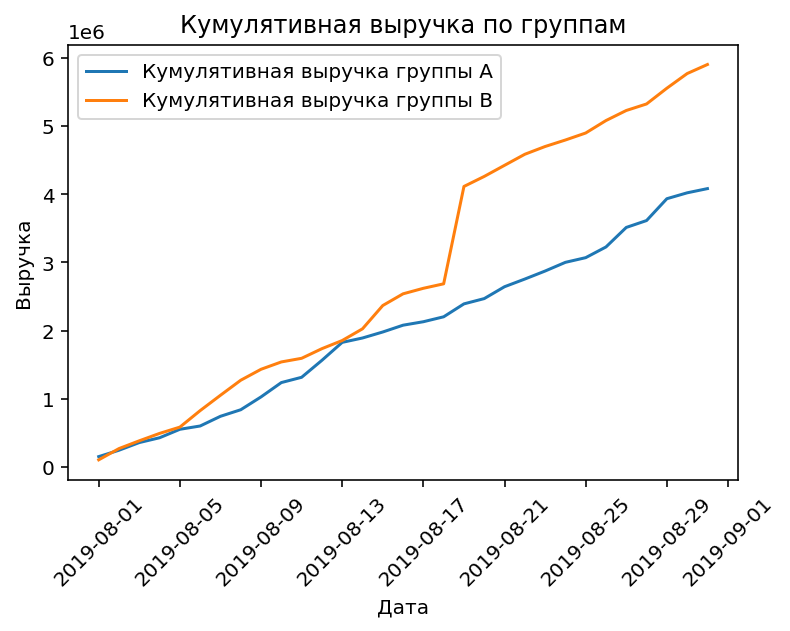

In [34]:
# Построим график выручки по группам
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='Кумулятивная выручка группы А')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='Кумулятивная выручка группы В')
plt.title("Кумулятивная выручка по группам")
plt.xlabel ('Дата')
plt.ylabel ('Выручка')
plt.xticks(rotation = 45)
plt.legend();

По данному графику мы можем заметить, что выручка у группы В с середины теста лидирует до конца теста. Нужно будет посмотреть на чистые данные.

### График кумулятивного среднего чека по группам. 

Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.

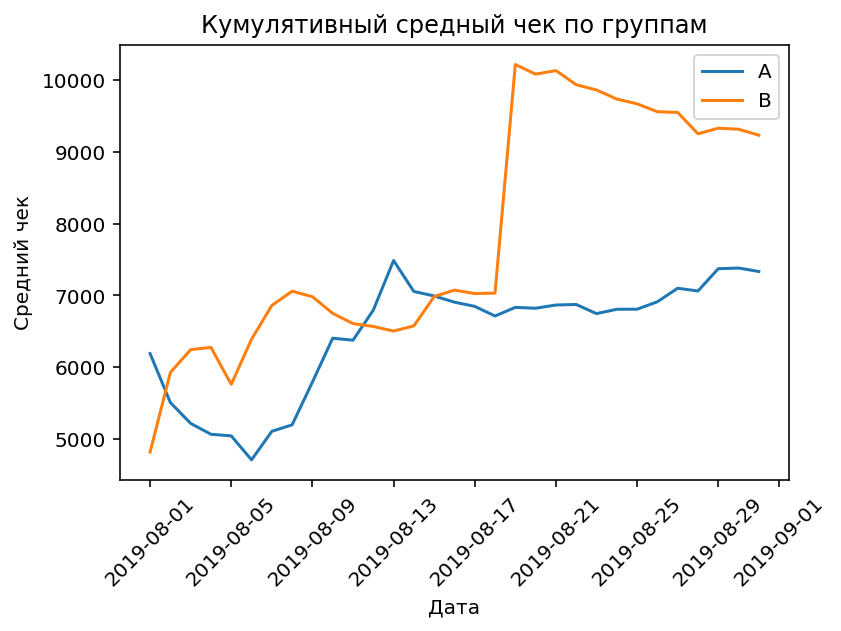

In [35]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title("Кумулятивный средный чек по группам")
plt.xlabel ('Дата')
plt.ylabel ('Средний чек')
plt.xticks(rotation = 45)
plt.legend();

Опять же лидирует группа В,но рост показателя слишком резкий, возможно это выбросы.

### График относительного изменения кумулятивного среднего чека группы B к группе A. 

Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

In [36]:
#Объединим таблицы cumulativeRevenueA и cumulativeRevenueB в переменной mergedCumulativeRevenue. 

mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

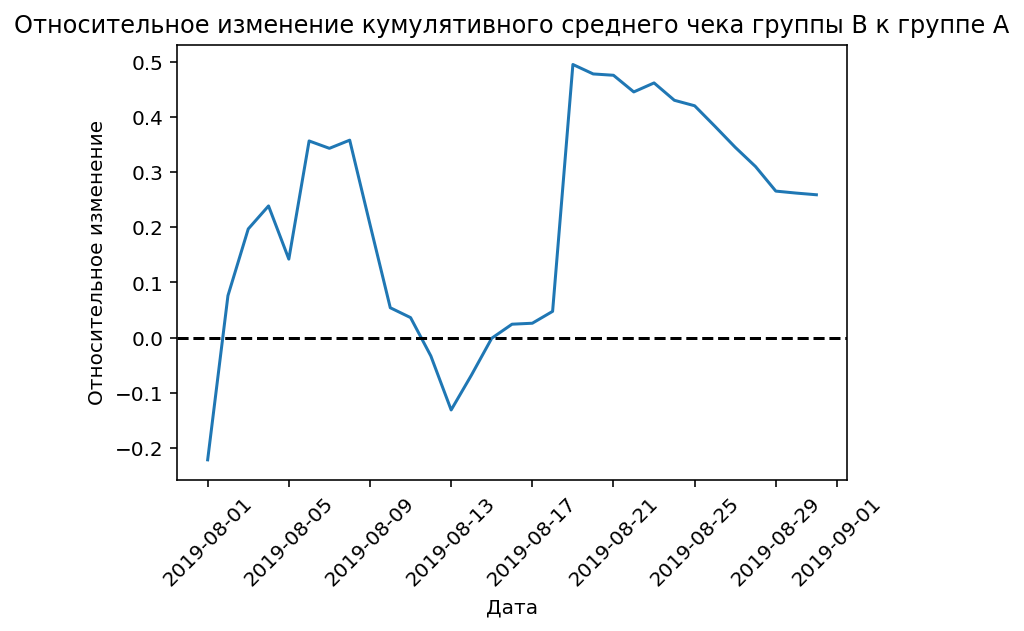

In [37]:
# Поcтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1);
plt.title("Относительное изменение кумулятивного среднего чека группы B к группе A")
plt.xlabel ('Дата')
plt.ylabel ('Относительное изменение')
plt.xticks(rotation = 45)
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');


По графику видим несколько пиковых значений, возможно, в эти даты были выбросы. В целом, пока нельзя сделать однозначные выводы, нужно продолжить тест.

### График кумулятивного среднего количества заказов на посетителя по группам. 

Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.

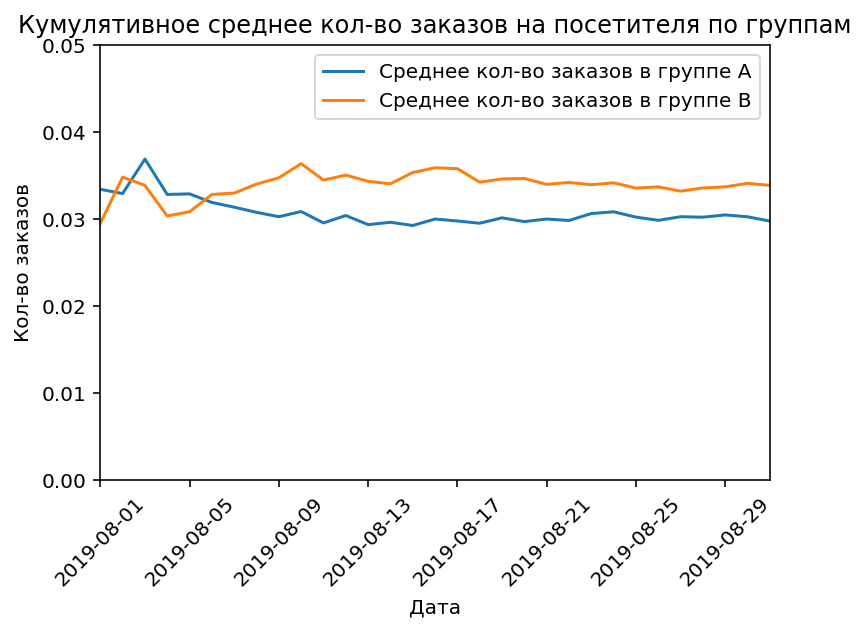

In [38]:
# считаем среднее кол-во заказов
cumulativeData['avg'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['avg'], label='Среднее кол-во заказов в группе А')
plt.plot(cumulativeDataB['date'], cumulativeDataB['avg'], label='Среднее кол-во заказов в группе B')
plt.legend()
plt.title("Кумулятивное среднее кол-во заказов на посетителя по группам")
plt.xlabel ('Дата')
plt.ylabel ('Кол-во заказов')
plt.xticks(rotation = 45)

# задаем масштаб осей 
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0, 0.05]);

По этому графику мы можем отметить, что больше заказов в группе В, но есть небольшие всплески в начале анализа. 

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 

Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.

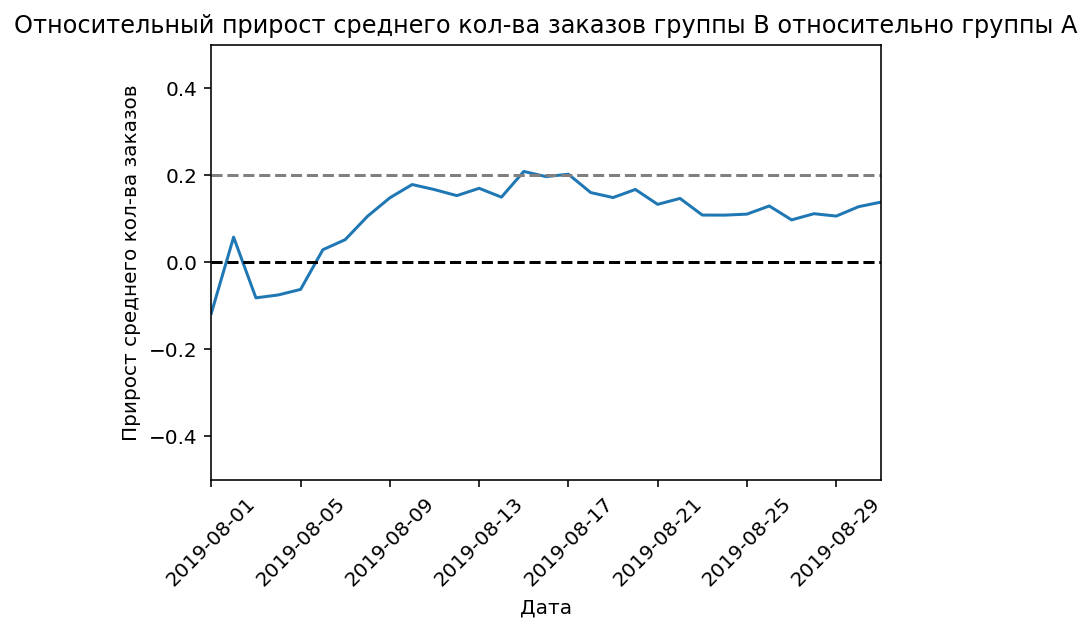

In [39]:
# Объединим таблицы cumulativeDataA и cumulativeDataB
mergedCumulativeAvg = cumulativeDataA[['date','avg']].merge(cumulativeDataB[['date','avg']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

#Построbv график относительного различия кумулятивной конверсии группы B к группе A. 

plt.plot(mergedCumulativeAvg['date'], mergedCumulativeAvg['avgB']/mergedCumulativeAvg['avgA']-1)
plt.title("Относительный прирост среднего кол-ва заказов группы B относительно группы A")
plt.xlabel ('Дата')
plt.ylabel ('Прирост среднего кол-ва заказов')


plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), -0.5, 0.5]);
plt.xticks(rotation = 45)
plt.show()

По графику мы видим, что группа В лидирует по среднему кол-ву заказов относительно группы А, прирост почти 20%.

### Точечный график количества заказов по пользователям. 

Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

In [40]:
# Создадим датафрейм ordersByUsers с кол-вом заказов по пользователям
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['visitor_id', 'orders']
ordersByUsers.sort_values(by='orders', ascending=False).head(10)


,visitor_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


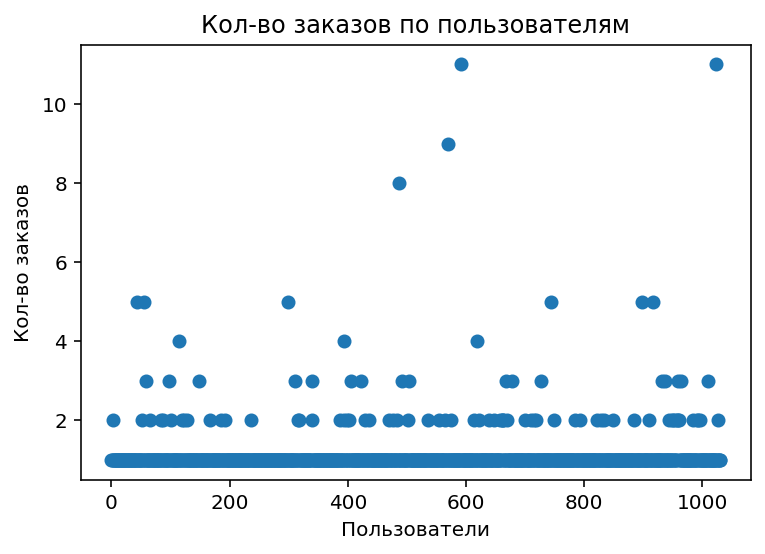

In [41]:
# Построим график кол-ва заказов по пользователям

x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title("Кол-во заказов по пользователям")
plt.xlabel ('Пользователи')
plt.ylabel ('Кол-во заказов')
plt.show;

По графику мы видим, что кол-во пользователей, заказавших более 2 заказов достаточно мало. Есть пользователи, которые сделали 9 и 11 заказов. Далее рассмотрим эти выбросы. 

### Расчет 95-го и 99-го перцентилей количества заказов на пользователя. 

Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [42]:
np.percentile(ordersByUsers['orders'], [90, 95, 99])

array([1., 2., 4.])

Около 5% пользователей сделали больше 2х заказов и около 1% сделали больше 4 заказов. Оставим в датафрейме пользователей, которые сделали  меньше 4 заказов.

### Точечный график стоимостей заказов.

Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

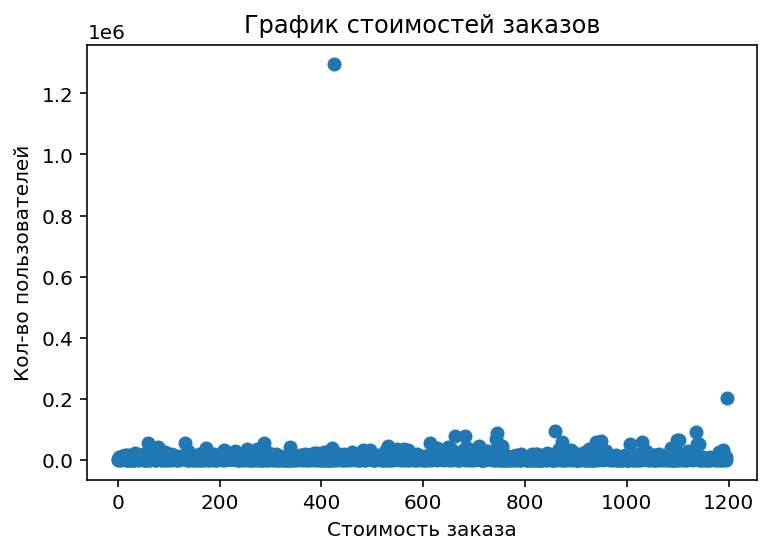

In [43]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title("График стоимостей заказов")
plt.xlabel ('Стоимость заказа')
plt.ylabel ('Кол-во пользователей');

Мы видим несколько выборосов, далее изучим их.

###  95-й и 99-й перцентили стоимости заказов. 

Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [44]:
np.percentile(orders['revenue'], [90, 95, 99])

array([18168. , 28000. , 58233.2])

Не более чем у 1% стоимость покупок больше 58 000 рублей, у около 5% пользователей стоимость заказа выше 28 000 рублей. Определим границы в районе 30 000 рублей.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. 

Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделайте выводы и предположения.


In [45]:
# Для анализа создадим таблицу data

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [46]:
# Cоздадим переменные ordersByUsersA и ordersByUsersB

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['user_id', 'orders']
print (ordersByUsersA)


ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['user_id', 'orders']
print (ordersByUsersB)

[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')]

        user_id  orders
0       8300375       1
1      11685486       1
2      54447517       1
3      66685450       1
4      78758296       1
..          ...     ...
498  4243832526       1
499  4256040402       7
500  4259830713       1
501  4266935830       1
502  4278982564       1

[503 rows x 2 columns]
        user_id  orders
0       5114589       1
1       6958315       1
2       8300375       1
3      39475350       1
4      47206413       1
..          ...     ...
581  4258103007       1
582  4266935830       1
583  4279090005       1
584  4281247801       1
585  4283872382       1

[586 rows x 2 columns]


[0      1
 1      1
 2      1
 3      1
 4      1
       ..
 498    1
 499    7
 500    1
 501    1
 502    1
 Name: orders, Length: 503, dtype: int64,
 0        0
 1        0
 2        0
 3        0
 4        0
         ..
 18228    0
 18229    0
 18230    0
 18231    0
 18232    0
 Name: orders, Length: 18233, dtype: int64]

In [47]:
# Объявим переменные sampleA и sampleB

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)



In [48]:
# Посчитаем статистическую значимость различия среднего количества заказов

print("{0:.5f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.01679
0.138


Гипотезы:

- H0- cтатистически значимых различий в среднем количестве заказов на посетителя между группами по «сырым» данным нет.
- H1- cтатистически значимые различия в среднем количестве заказов на посетителя между группами по «сырым» данным есть.

Значение p-value = 0.01679, что меньше 0.05, что может говорить о том, что нулевая гипотеза может быть отвергнута. Среднее кол-во заказов между группами А и В не равны.

Относительный прирост среднего группы В к конверсии группы А около 13.8%.

### Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным. 

Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.

Гипотезы:

- H0- статистически значимых различий в среднем чеке заказа между группами по «сырым» данным нет.
- H1- cтатистически значимые различия в среднем чеке заказа между группами по «сырым» данным есть.

In [49]:
print('{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.729
0.259


P-value = 0.729, что больше 0.05, что может говорить о том, что значимых отличий в средних чеках между группами нет. 

Однако относительное различие чека между сегментами составляет 25.9%.

### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.

Ранее мы определили, что аномальной границей станет 4 заказа и заказы на сумму свыше 30 000 рублей. 

In [50]:
# Сделаем срезы пользователей с числом заказов больше 3 — usersWithManyOrders и пользователей, совершивших заказы дороже 30 000 — usersWithExpensiveOrders


usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 3]['user_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 3]['user_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))

1099    148427295
18      199603092
928     204675465
23      237748145
684     358944393
dtype: int64


In [51]:
#Создадим переменные sampleAFiltered и sampleBFiltered, в которых сохраним очищенные данные о заказах

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['user_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['user_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('{0:.5f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.01832
0.148


Гипотезы:

- H0- статистически значимых различий в среднем количестве заказов на посетителя между группами по «очищенным» данным нет.
- H1- cтатистически значимые различия в среднем количестве заказов на посетителя между группами по «очищенным» данным есть.

Значение p-value = 0.01832, что меньше 0.05, что может говорить о том, что нулевая гипотеза может быть отвергнута. Среднее кол-во заказов между группами А и В в очищенных данных не равны.

Относительный прирост среднего группы В к конверсии группы А около 14.8%.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

In [52]:
print(
    '{0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.958
-0.020


Гипотезы:

- H0- статистически значимых различий в среднем чеке заказа между группами по «очищенным» данным нет.
- H1- cтатистически значимые различия в в среднем чеке заказа между группами по «очищенным» данным есть.

P-value = 0.958, в "очищенных данных" увеличился, но средний чек группы B в "очищенных данных" оказался ниже среднего чека группы A. и составила 2%.

## Вывод.

По итогам приоретизации гипотез и проведения А/В тестирования можно сделать следующие выводы:

1.

- После применения фреймоворка ICE наиболее наиболее перспективными являются гипотезы под номерами 8,0 и 7.
- После применения фреймворка RICE помимо гипотез 7 и 0, появились новые гипотезы 2 и 6.
- Основными различиями при приоритезации гипотез между фрейморками ICE и RICE является наличие параметра Reach, который показывает охват пользователей по 10-балльной шкале. Поэтому, после применения фреймоворка RICE. наиболее перспективными гипотезами стали гипотезы под номерами 7,2,0 и 6.

2. 2.1  

   В A/B тесте участвовали 2 группы.В группах были повторяющиеся пользователи, но их кол-во меньше 5%, поэтому мы их оставили.Тест продолжался 30 дней.


2.2  
- При анализе кумулятивной выручки по группах, мы обнаружили, что выручка у группы В вышк примерно с середины теста и  лидирует до конца теста. 
- Анализ кумулятивного среднего чека по группам опять же лидирует группа В, но у нее имеется слишком резкий скачек, что может быть обусловлено аномально высокими покупками (выбросами).
- По графику относительного изменения кумулятивного среднего чека группы В к группе А мы также видим аномально высокие значения, что означает выбосы.

2.3 
- После анализа кумулятивного среднего кол-ва заказов на посетителя по группам, мы видим, что группа В имеет больше заказов.
- График относительного прироста среднего кол-ва заказов группы В относительно группы А показывает, что группа В лидирует по среднему кол-ву заказов относительно группы А, прирост почти 20%.

2.4
- После точеного графика кол-ва заказов по пользователям, мы нашли выбросы.
- Около 5% пользователей сделали больше 2х заказов и около 1% сделали больше 4 заказов. Оставим в датафрейме пользователей, которые сделали меньше 4 заказов.
- График стоимостей заказов мы также нашли аномально высокие значения.
- Не более чем у 1% стоимость покупок больше 58 000 рублей, у около 5% пользователей стоимость заказа выше 28 000 рублей. Определим границы в районе 30 000 рублей.

2.5
- После анализа статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным, мы определили, что значение p-value = 0.01679, что меньше 0.05, что может говорить о том, что нулевая гипотеза может быть отвергнута. Среднее кол-во заказов между группами А и В не равны. Относительный прирост среднего кол-ва группы В к конверсии группы А около 13.8%.
- После анализа статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным, мы получили почти те же значения: p-value = 0.01832, может говорить о том, что нулевая гипотеза может быть отвергнута. Среднее кол-во заказов между группами А и В в очищенных данных не равны. Относительный прирост среднего группы В к конверсии группы А около 14.8%.

2.6
- Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным дала понять, что значимых отличий в средних чеках между группами нет, т. к P-value = 0.729, что больше 0.05. Однако относительное различие чека между сегментами составляет 25.9%.
- На "очищенных данных" статистическая значимость различий в среднем чеке заказа между группами показала, что  значение P-value увеличился и составило 0.958, но средний чек группы B в "очищенных данных" оказался ниже среднего чека группы A. и составила 2%. Скорее всего это связано с тем, что мы убрали выбросы из группы В, которые влияли на средний чек группы. 


3. Мы имеем:
- Нет статистически значимого различия по среднему количеству заказов между группами ни по «сырым», ни по данным после фильтрации аномалий. Группа В имеет большее среднее кол-во заказов.
- Есть статистически значимые различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий, в "сырых" данных различие в пользу группы В почти 25%, однако после очистки данных, группа А имеет преимущество в 2 %;
- По графикам различия среднего количества заказов между группами сообщает, что результаты группы B лучше группы A почти на 20%, однако при анализе кумулятивного среднего кол-во заказов на посетителя по группам и кумулятивного среднего чека по группам (без выбросов), группа А не сильно отстает.

Рекомендации:
- Продолжить тест, посмотреть на поведение обоих групп, так как в группе В в начале тестирования имеются выбросы. Стоит посмотреть на средние чеки по группам через некоторое время еще раз.

